# Run Models on GPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/run_models_on_gpu.ipynb)

## Setup

In [1]:
MODE = "local"  # "colab" | "colab-dev" | "local"

In [ ]:
if MODE == "colab":
    !pip install -q lczerolens
elif MODE == "colab-dev":
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b main
    !pip install -q ./lczerolens

In [ ]:
!gdown 1TI429e9mr2de7LjHp2IIl7ouMoUaDjjZ -O leela-network.onnx

In [4]:
import torch

if not torch.cuda.is_available():
    raise RuntimeError("This notebook requires a GPU")

## Load a Model

Load a leela network from file (already converted to `onnx`):

In [5]:
from lczerolens import LczeroModel

cpu_model = LczeroModel.from_path("leela-network.onnx")

gpu_model = LczeroModel.from_path("leela-network.onnx").to("cuda")

## Predict a Move

The defined model natively integrates with `python-cess`. Use the utils to predict a policy vector and obtain an UCI move:

In [6]:
import chess
import time

from lczerolens.play import PolicySampler

board = chess.Board()

cpu_sampler = PolicySampler(cpu_model, use_argmax=True)
gpu_sampler = PolicySampler(gpu_model, use_argmax=True)

t0 = time.time()
next(iter(cpu_sampler.get_next_moves([board])))
print("CPU time:", time.time() - t0)

t0 = time.time()
next(iter(gpu_sampler.get_next_moves([board])))
print("GPU time:", time.time() - t0)

CPU time: 0.012004613876342773
GPU time: 0.9514670372009277


In [7]:
def board_generator(N):
    for _ in range(N):
        yield chess.Board()


Ns = [10, 50, 100, 1000, 2000, 5_000, 10_000, 15_000, 20_000]
cpu_times = []
gpu_times = []

for N in Ns:
    t0 = time.time()
    next(iter(cpu_sampler.get_next_moves(board_generator(N))))
    cpu_times.append(time.time() - t0)
    t0 = time.time()
    next(iter(gpu_sampler.get_next_moves(board_generator(N))))
    gpu_times.append(time.time() - t0)

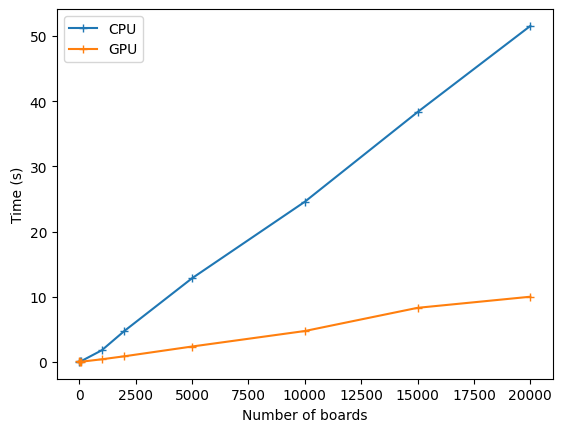

In [8]:
import matplotlib.pyplot as plt

plt.plot(Ns, cpu_times, label="CPU", marker="+")
plt.plot(Ns, gpu_times, label="GPU", marker="+")
plt.xlabel("Number of boards")
plt.ylabel("Time (s)")
plt.legend()
plt.show()